<a href="https://colab.research.google.com/github/dekennedy/2020/blob/master/autotel_neighborhood_cars_demand_extract_fork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoTel Shared Cars Availability
* This notebook explores the AutoTel Dataset and aggregates it for demand forecasting prediction. 
* The dataset contains points of parked cars collected from [autotel](https://www.autotel.co.il/en/).
* A [blog post](https://blog.doit-intl.com/using-bigquery-ml-to-predict-car-share-availability-f929310ec662) on processing the data using BigQuery ML
* [the original BigQuery dataset](https://bigquery.cloud.google.com/table/gad-playground-212407:doit_intl_autotel_public.car_locations)  updates frequently

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import r2_score , mean_absolute_error, mean_squared_error , median_absolute_error
warnings.filterwarnings("ignore")
%matplotlib inline

Lets Start by loading the data

In [ ]:
# We start by reading the data
df = pd.read_csv('../input/autotel-shared-car-locations/sample_table.csv')
df.sample(5)

,timestamp,latitude,longitude,total_cars,carsList
1669694,2018-12-22 20:43:05.739467 UTC,32.127629,34.831681,2,"[61, 268]"
5392029,2018-12-28 23:27:12.929016 UTC,32.040491,34.765620,1,[45]
6451370,2018-12-30 06:01:09.240426 UTC,32.086678,34.791337,0,[]
3689395,2018-12-29 15:42:32.430664 UTC,32.111722,34.816493,0,[]
3678251,2019-01-10 08:32:13.940046 UTC,32.102224,34.785543,0,[]


In [ ]:
df.describe()

,latitude,longitude,total_cars
count,6.683756e+06,6.683756e+06,6.683756e+06
mean,3.208337e+01,3.478899e+01,6.432292e-01
std,2.639419e-02,2.200057e-02,6.984731e-01
min,3.195223e+01,3.472998e+01,0.000000e+00
25%,3.206119e+01,3.477352e+01,0.000000e+00
50%,3.208144e+01,3.478642e+01,1.000000e+00
75%,3.210724e+01,3.479933e+01,1.000000e+00
max,3.214566e+01,3.495142e+01,1.000000e+01


Some of the rows indicate empty parking spots. These spots are reserved for AutoTel cars, but no car was parked there art the time. Since we are only interested in the cars location, we will filter these rows to save computation and memory

In [ ]:
df = df[df['total_cars'] > 0]

In [ ]:
df_cars_by_time = df.groupby('timestamp').agg({'total_cars':'sum'}).reset_index()
df_cars_by_time.sample(5)

,timestamp,total_cars
14243,2019-01-02 23:00:13.567572 UTC,241
12252,2018-12-31 01:51:15.867417 UTC,254
18360,2019-01-08 21:58:57.668134 UTC,222
11248,2018-12-29 14:58:43.908041 UTC,226
6338,2018-12-22 12:14:32.870327 UTC,221


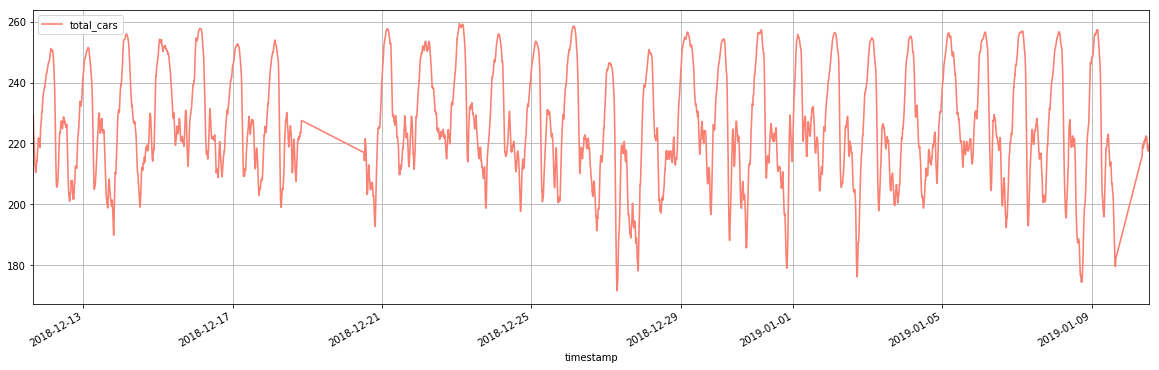

In [ ]:
df_cars_by_time['timestamp'] = df_cars_by_time['timestamp'].apply(pd.Timestamp)
df_cars_by_time.set_index('timestamp').sort_index().rolling('60min').mean().plot(figsize=(20,6), c='salmon', lw=1.6)
plt.grid()
plt.show()

* We can see that tge max available cars is 260, so we can assume that this is the total number of cars available in AutoTel.
* By assuming this we will calculate the usage rate.

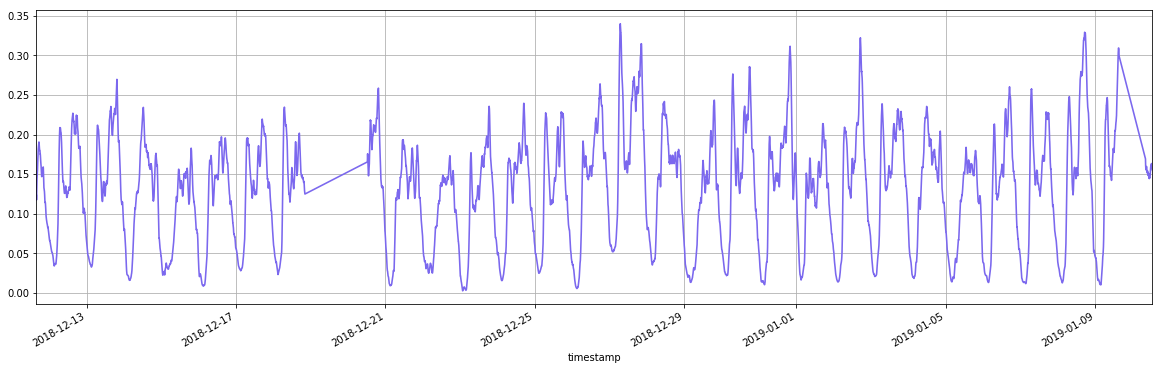

In [ ]:
df_cars_by_time['usage_rate'] = (260 - df_cars_by_time['total_cars']) / 260
df_cars_by_time.set_index('timestamp').sort_index()['usage_rate'].rolling('60min').mean().plot(figsize=(20,6), c='mediumslateblue', lw=1.6)
plt.grid()
plt.show()

That's nice, the usage varies between 2.5% at night and 25% at peak times! now lets look at the trend, is the usage growing or decreasing over time?

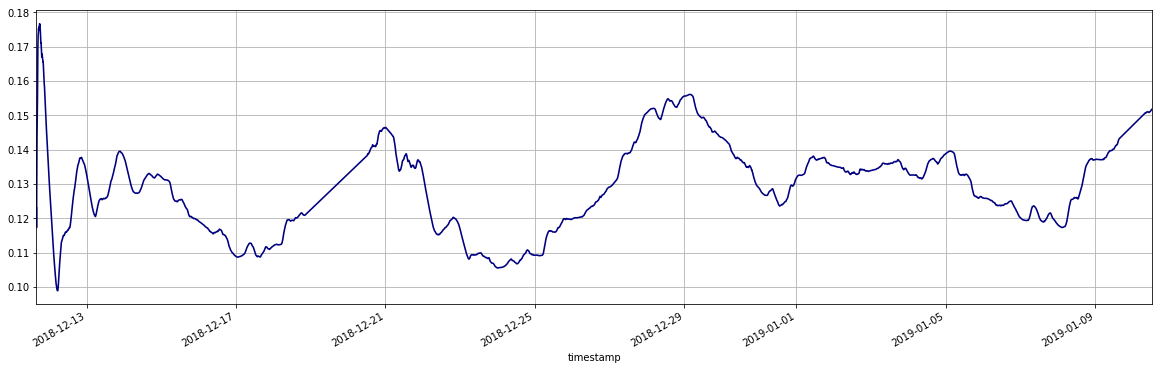

In [ ]:
df_cars_by_time['usage_rate'] = (260 - df_cars_by_time['total_cars']) / 260
df_cars_by_time.set_index('timestamp').sort_index()['usage_rate'].rolling('3D').mean().plot(figsize=(20,6), c='navy', lw=1.6)
plt.grid()
plt.show()

## Analyzing Usage Patterns by Time

In order to analyze the data by time we need to consider another issu. We notice is the time zone, Tel Aviv is not in UTC timezome, making all analysis shifted. Let's shift back!

In [ ]:
# Convert timezone
timestamps = pd.DatetimeIndex(df_cars_by_time['timestamp'])
timestamps = timestamps.tz_convert('Asia/Jerusalem')

df_cars_by_time['local_time'] = timestamps

#Extract time features
df_cars_by_time['weekday'] = df_cars_by_time['local_time'].dt.weekday_name
df_cars_by_time['hour'] = df_cars_by_time['local_time'].dt.hour

In [ ]:
df_cars_by_time.head() # Looks right!

,timestamp,total_cars,usage_rate,local_time,weekday,hour
0,2018-12-11 15:48:53.592141+00:00,228,0.123077,2018-12-11 17:48:53.592141+02:00,Tuesday,17
1,2018-12-11 15:50:59.656592+00:00,231,0.111538,2018-12-11 17:50:59.656592+02:00,Tuesday,17
2,2018-12-11 15:53:04.995927+00:00,228,0.123077,2018-12-11 17:53:04.995927+02:00,Tuesday,17
3,2018-12-11 15:55:10.216045+00:00,225,0.134615,2018-12-11 17:55:10.216045+02:00,Tuesday,17
4,2018-12-11 15:57:15.943339+00:00,222,0.146154,2018-12-11 17:57:15.943339+02:00,Tuesday,17


## Analyze usage patterns by day and hour

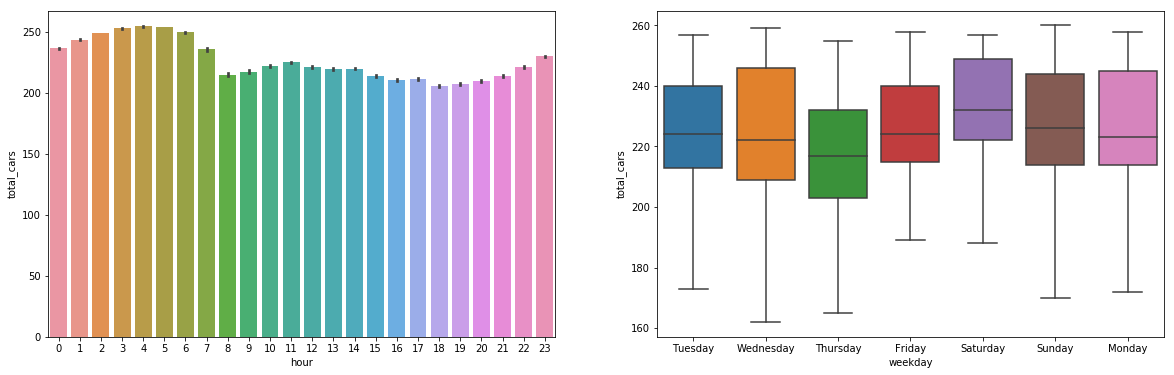

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.barplot(x='hour', y='total_cars', data=df_cars_by_time)
plt.subplot(122)
sns.boxplot(x='weekday', y='total_cars', data=df_cars_by_time, showfliers=False)

plt.show()

In [ ]:
df_cars_by_time['usage_rate'] = (260 - df_cars_by_time['total_cars']) / 260

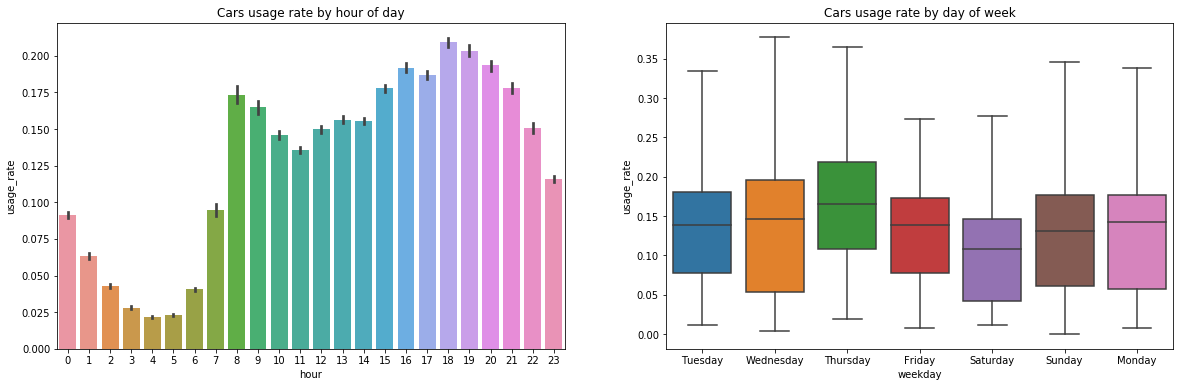

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.barplot(x='hour', y='usage_rate', data=df_cars_by_time)
plt.title('Cars usage rate by hour of day')
plt.subplot(122)
sns.boxplot(x='weekday', y='usage_rate', data=df_cars_by_time, showfliers=False)
plt.title('Cars usage rate by day of week')

plt.show()

* Looks much better isn't it? during the night the usage drops to as much as 2.5%, while at peak times almost 20% of the cars are in use.
* Weekdays in israel are Sunday to Thursday, the weekend is Friday and Saturday. This may explain why Thursday has the highest usage rate on average

## Plotting the data on a map
This geographical data can be presented on a map, showing where people park the cars

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
df_locations = df.groupby(['latitude', 'longitude', 'timestamp']).sum().reset_index().sample(1500)
df_locations.head()

,latitude,longitude,timestamp,total_cars
903670,32.056610,34.773590,2018-12-13 17:54:29.272034 UTC,1
2036749,32.089715,34.779953,2018-12-31 17:18:36.685788 UTC,1
1737744,32.079074,34.783401,2018-12-25 12:30:03.131716 UTC,1
3058857,32.119370,34.817490,2018-12-25 16:11:06.312135 UTC,1
464501,32.047810,34.756990,2018-12-27 21:11:48.880222 UTC,1


In [ ]:
m = folium.Map([df_locations.latitude.mean(), df_locations.longitude.mean()], zoom_start=11)
for index, row in df_locations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=row['total_cars'] * 6,
                        fill_color="#3db7e4", 
                       ).add_to(m)
    
points = df_locations[['latitude', 'longitude']].as_matrix()
m.add_children(HeatMap(points, radius=15)) # plot heatmap

m

## Predicting the number of available cars per neighborhood 

we peovide additional data of neighborhood polygons of the city of Tel Aviv. This data will enable us to group the data by neighborhood and later predict the number of available cars per neighborhood!
* Disclaimer: Kaggle Kernels do not support GeoPandas, so I implemented my own geo Joins wich are not efficient. Hopefully they will add it soon!

In [ ]:
from shapely.geometry import Point, Polygon
from shapely import wkt

In [ ]:
df_neighborhood = pd.read_csv('../input/tel-aviv-neighborhood-polygons/tel_aviv_neighborhood.csv')
df_neighborhood.head()

,oid_shchuna,neighborhood_id,neighborhood_name,date_import,Shape_Area,area_polygon
0,1,3,Sde Dov area,2015-10-06 08:36:43 UTC,1.307955e+06,"POLYGON ((34.788389 32.123656, 34.788383 32.12..."
1,2,2,Spring Cliffs,2015-10-06 08:36:43 UTC,1.288925e+06,"POLYGON ((34.796243 32.130388, 34.795859 32.12..."
2,3,7,Ramat Aviv c,2015-10-06 08:36:43 UTC,1.101582e+06,"POLYGON ((34.808554 32.128712, 34.808641 32.12..."
3,4,11,Tel aviv university,2015-10-06 08:36:43 UTC,1.459851e+06,"POLYGON ((34.802354 32.118062, 34.80239 32.118..."
4,5,6,North Star,2015-10-06 08:36:43 UTC,4.212298e+05,"POLYGON ((34.783522 32.098636, 34.783493 32.09..."


In [ ]:
def load_and_close_polygon(wkt_text):
    poly = wkt.loads(wkt_text)
    point_list = poly.exterior.coords[:]
    point_list.append(point_list[0])
    
    return Polygon(point_list)

In [ ]:
# Lets transform the WKS's to Polygon Objects and save it to a GeoPandas DataFrame
df_neighborhood['polygon'] = df_neighborhood['area_polygon'].apply(load_and_close_polygon)
neighborhood_map = df_neighborhood.set_index('neighborhood_name')['polygon'].to_dict()

In [ ]:
sample_df = df.sample(10000)
sample_df['points'] = sample_df.apply(lambda row : Point([row['longitude'], row['latitude']]), axis=1)
sample_df.head()

,timestamp,latitude,longitude,total_cars,carsList,points
1928656,2018-12-26 23:23:07.55451 UTC,32.084954,34.783570,1,[182],POINT (34.78357 32.084954)
5018548,2018-12-21 02:53:33.400595 UTC,32.042400,34.758260,1,[65],POINT (34.75826 32.0424)
5550291,2018-12-25 13:32:36.929421 UTC,32.054720,34.800990,2,"[184, 197]",POINT (34.80099000000001 32.05472)
5797261,2018-12-26 05:54:26.480244 UTC,32.089715,34.779953,1,[227],POINT (34.77995300000001 32.08971500000001)
5290073,2019-01-01 05:29:52.156771 UTC,32.056240,34.806330,1,[133],POINT (34.80633 32.05624)


In [ ]:
poly_idxs = sample_df['points'].apply(lambda point : np.argmax([point.within(polygon) for polygon in list(neighborhood_map.values())]))
poly_idxs = poly_idxs.apply(lambda x: list(neighborhood_map.keys())[x])
sample_df['neighborhood'] = poly_idxs.values
sample_df.head()

,timestamp,latitude,longitude,total_cars,carsList,points,neighborhood
1928656,2018-12-26 23:23:07.55451 UTC,32.084954,34.783570,1,[182],POINT (34.78357 32.084954),The new north - the state square
5018548,2018-12-21 02:53:33.400595 UTC,32.042400,34.758260,1,[65],POINT (34.75826 32.0424),Jaffa College Tel Aviv and Dakar
5550291,2018-12-25 13:32:36.929421 UTC,32.054720,34.800990,2,"[184, 197]",POINT (34.80099000000001 32.05472),Lights
5797261,2018-12-26 05:54:26.480244 UTC,32.089715,34.779953,1,[227],POINT (34.77995300000001 32.08971500000001),Old North - Northern part
5290073,2019-01-01 05:29:52.156771 UTC,32.056240,34.806330,1,[133],POINT (34.80633 32.05624),Neve Chen


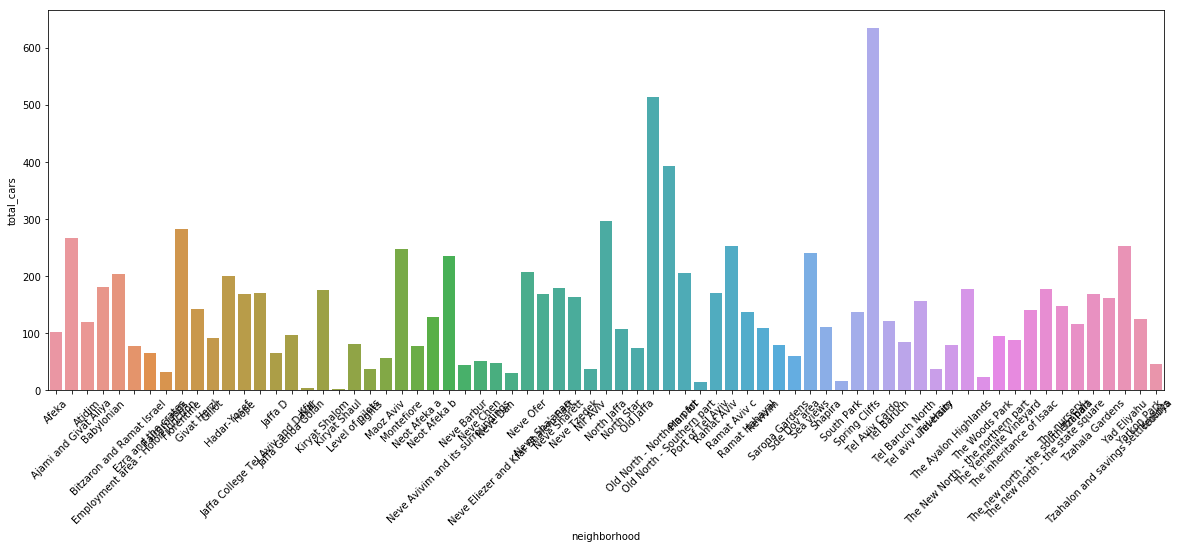

In [ ]:
plt.figure(figsize=(20,7))
sns.barplot(x='neighborhood', y='total_cars', data=sample_df.groupby('neighborhood').count().reset_index())
plt.xticks(rotation=45)
plt.show()

## Predicting Car Availability using LightGBM

Now lets imagine that we'd like to generate predictions to how cars will be distributed between neighborhoods in the city. So in this sample code we will try to use LightGBM to predict the number of available car in a neighborhood

In [ ]:
import lightgbm as lgb

In [ ]:
df_sample = df.copy()

In [ ]:
df_timestamps = pd.DataFrame()
df_timestamps['timestamp'] = df_sample.timestamp.drop_duplicates()
timestamps = pd.DatetimeIndex(df_timestamps['timestamp']).tz_localize('UTC')
df_timestamps['local_time'] = timestamps.tz_convert('Asia/Jerusalem')

TypeError: Already tz-aware, use tz_convert to convert.

In [ ]:
df_sample = df_sample.merge(df_timestamps, on='timestamp', how='left')

In [ ]:
# Again no reason to calculate on duplicate points, it's very expensive!
df_points = df_sample[['longitude','latitude']].drop_duplicates()
df_points['points'] = df_points.apply(lambda row : Point([row['longitude'], row['latitude']]), axis=1)
poly_idxs = df_points['points'].apply(lambda point : np.argmax([point.within(polygon) for polygon in list(neighborhood_map.values())]))
poly_idxs = poly_idxs.apply(lambda x: list(neighborhood_map.keys())[x])
df_points['neighborhood'] = poly_idxs.values

In [ ]:
df_sample = df_sample.merge(df_points[['longitude', 'latitude', 'neighborhood']], on=['longitude', 'latitude'], how='left')

In [ ]:
df_sample['time_in_seconds'] = pd.to_datetime(df_sample['local_time']).values.astype(np.int64) // 10**6

seconds_in_day = 24 * 60 * 60
seconds_in_week = 7 * seconds_in_day

df_sample['sin_time_day'] = np.sin(2*np.pi*df_sample['time_in_seconds']/seconds_in_day)
df_sample['cos_time_day'] = np.cos(2*np.pi*df_sample['time_in_seconds']/seconds_in_day)

df_sample['sin_time_week'] = np.sin(2*np.pi*df_sample['time_in_seconds']/seconds_in_week)
df_sample['cos_time_week'] = np.cos(2*np.pi*df_sample['time_in_seconds']/seconds_in_week)

df_sample['weekday'] = df_sample['local_time'].dt.weekday
df_sample['hour'] = df_sample['local_time'].dt.hour

df_sample.sample(5)

KeyError: 'local_time'

### Does our data  contain multiple parking spots per Neighborhood?
* i.e multiple rounded latLongs per neighborhood? 
* We may want to roundup the latlongs , in case reporting comes from the car level, rather than the parking spot(s)

In [ ]:
df_sample[['longitude', 'latitude', 'neighborhood']].groupby('neighborhood').nunique()

,longitude,latitude,neighborhood
neighborhood,,,
Afeka,260,283,1
Ajami and Givat Aliya,374,507,1
Atidim,156,155,1
Babylonian,418,402,1
Bitzaron and Ramat Israel,484,498,1
...,...,...,...
Tzahala Gardens,418,365,1
Tzahalon and savings settlements,360,408,1
Yad Eliyahu,730,590,1


In [ ]:
df_sample["LL2"] = df_sample['longitude'].round(2).astype(str)+ df_sample['latitude'].round(2).astype(str)

In [ ]:
df_sample[['LL2', 'neighborhood']].groupby('neighborhood').nunique()

,LL2,neighborhood
neighborhood,,
Afeka,2,1
Ajami and Givat Aliya,3,1
Atidim,2,1
Babylonian,3,1
Bitzaron and Ramat Israel,4,1
...,...,...
Tzahala Gardens,3,1
Tzahalon and savings settlements,4,1
Yad Eliyahu,4,1


* We see that looking at the "parking lot" level would mean roughly Tripling + the amount of rows/samples in our data to predict on. This might be a bit too much, although it would be more relevant for the level of taking action, i.e "where are there missing cars + a demand for cars"


In [ ]:
## Sde Dov looks weird. Let's check for odd values in latlongs , based on frequency
#### TODO 

# df_sample[['longitude', 'latitude', 'neighborhood']]['longitude'].value_counts()

## Back to merging + aggregation by Neighborhood: 
*  *Changed* : we will look at the hourly level, not minute level. (Could also do every half hour maybe?)

* Alternative target: Per "parking lot" = by LatLong2 `LL2`

In [ ]:
aggs = {}
aggs['total_cars'] = 'sum'
aggs['sin_time_day'] = 'mean'
aggs['cos_time_day'] = 'mean'
aggs['sin_time_week'] = 'mean'
aggs['cos_time_week'] = 'mean'
aggs['weekday'] = 'first'
aggs['hour'] = 'first'
# Mode is problematic with agg
aggs['latitude'] =   'first' # pd.Series.mode()#lambda x: x.mode #pd.Series.mode()#
aggs['longitude'] =  'first' # pd.Series.mode() #lambda x: x.mode #pd.Series.mode() # 'first'

# 30 minute resample
df_sample = df_sample.set_index('local_time').groupby([pd.Grouper(freq='1800s'), 'neighborhood']).agg(aggs).reset_index()

# df_sample.set_index('local_time').groupby([pd.Grouper(freq='60s'), 'neighborhood']).agg(aggs).reset_index().tail()

print(df_sample.shape)

df_sample.sample(6)

KeyError: "None of ['local_time'] are in the columns"

In [ ]:
df_sample.to_csv("autoTel_30m_Neighborhoods_v1.csv.gz",index=False,compression="gzip")

# Featurize for ML
* Temporal split

In [ ]:
df_sample['neighborhood'] = df_sample['neighborhood'].astype('category')
df_sample['weekday'] = df_sample['weekday'].astype('category')
df_sample['hour'] = df_sample['hour'].astype('category')

KeyError: 'weekday'

In [ ]:
df_train = df_sample[df_sample['local_time'] < '2019-01-04']
df_test = df_sample[df_sample['local_time'] >= '2019-01-04']

print('train_shape: ', df_train.shape)
print('test_shape: ', df_test.shape)

# df_train.to_csv("autoTel_train_30m_Neighborhoods.csv.gz",index=False,compression="gzip")
# df_test.to_csv("autoTel_test_30m_Neighborhoods.csv.gz",index=False,compression="gzip")

KeyError: 'local_time'

In [ ]:
features = ['neighborhood', 'sin_time_day', 'cos_time_day', 'sin_time_week', 'cos_time_week', 'weekday', 'hour']
target = 'total_cars'

In [ ]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=250)

In [ ]:
gbm.fit(df_train[features], df_train[target],
        eval_set=[(df_test[features], df_test[target])],
        eval_metric='mse',
        early_stopping_rounds=5,
      )

NameError: name 'df_train' is not defined

In [ ]:
df_test['prediction'] = gbm.predict(df_test[features])

NameError: name 'df_test' is not defined

In [ ]:
print("evaluation:")
print("r2_score:",r2_score(y_true=df_test['total_cars'], y_pred=df_test['prediction']))
print("mean_absolute_error:",mean_absolute_error(y_true=df_test['total_cars'], y_pred=df_test['prediction']))
print("mean_squared_error:",mean_squared_error(y_true=df_test['total_cars'], y_pred=df_test['prediction']))
print("median_absolute_error:",median_absolute_error(y_true=df_test['total_cars'], y_pred=df_test['prediction']))


evaluation:


NameError: name 'df_test' is not defined

In [ ]:
df_test.plot(kind='scatter', x='total_cars', y='prediction', lw=0, s=0.4, figsize=(20,6))
plt.show()

NameError: name 'df_test' is not defined